This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

Update the John Holkins, Covid-19 data https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [2]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Province_State',
            'place': 'California',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (1,1,0), # I initially tried p,d,q of 7,2,0 based on the ACF and PACF. It did not converge.
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '12-31-2020'}

The "data date" is 2020-05-27 00:00:00

ADF Statistic: -1.877240
p-value: 0.342843
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589


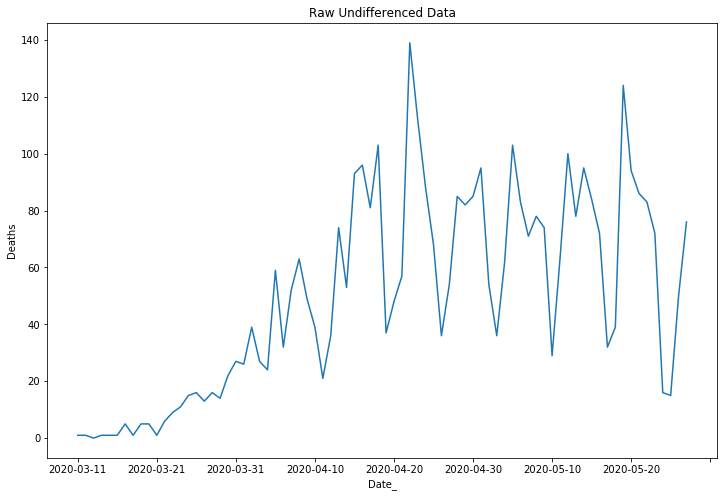

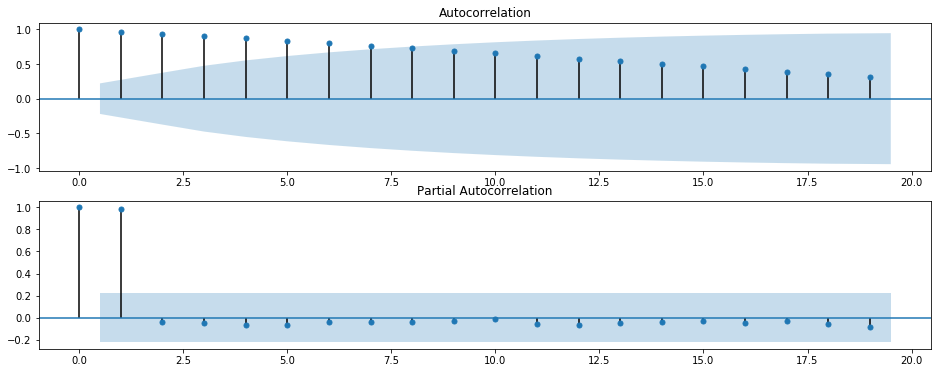

ARIMA(0, 0, 1) RMSE=1352.277
ARIMA(0, 1, 1) RMSE=49.455
ARIMA(0, 1, 2) RMSE=43.280
ARIMA(0, 2, 1) RMSE=31.973
ARIMA(0, 2, 2) RMSE=29.025
ARIMA(1, 0, 0) RMSE=76.982
ARIMA(1, 1, 0) RMSE=32.087
ARIMA(1, 2, 0) RMSE=32.611
ARIMA(2, 1, 0) RMSE=32.226
ARIMA(2, 2, 0) RMSE=31.771
Best ARIMA(0, 2, 2) RMSE=29.025
RMSE: 29.025
               0
count  40.000000
mean   -1.047533
std    29.375262
min   -59.508446
25%   -13.718594
50%    -3.152307
75%    15.035921
max    86.713688


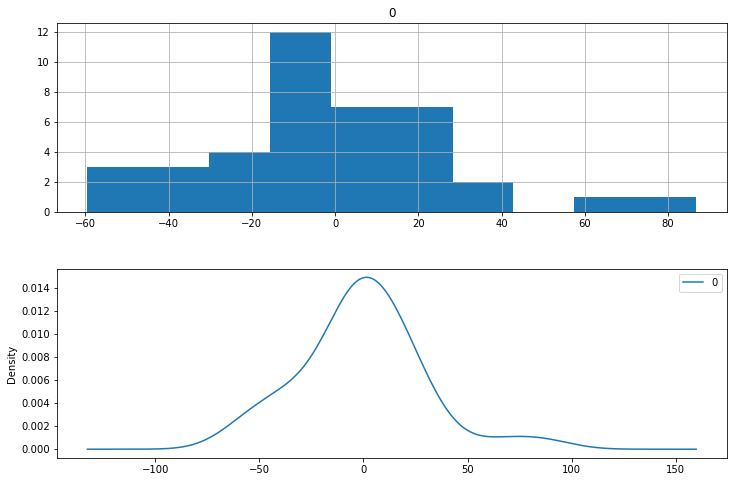


bias IS saved in arg_dict["bias"] for subsequent run is: -1.0475327748134475 

RMSE: 29.006
                  0
count  4.000000e+01
mean   6.821210e-14
std    2.937526e+01
min   -5.846091e+01
25%   -1.267106e+01
50%   -2.104774e+00
75%    1.608345e+01
max    8.776122e+01


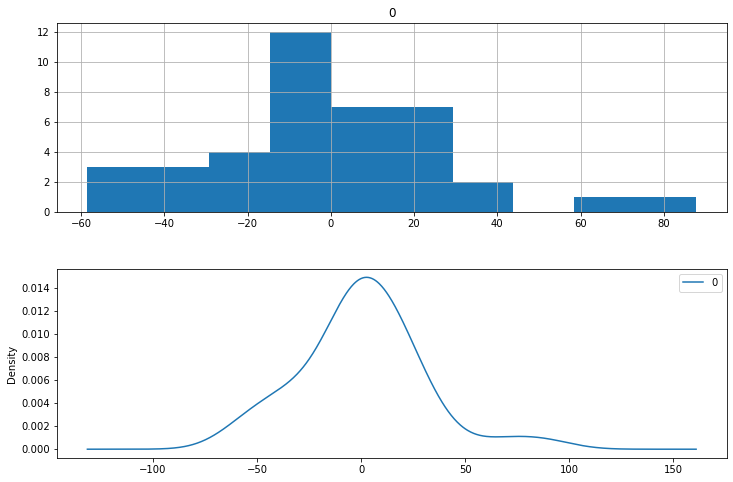


bias NOT saved in arg_dict["bias"] for subsequent run is: 6.821210263296962e-14 



In [3]:
# Load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Deaths for California for tomorrow (input data plus 1 day) are 3,875


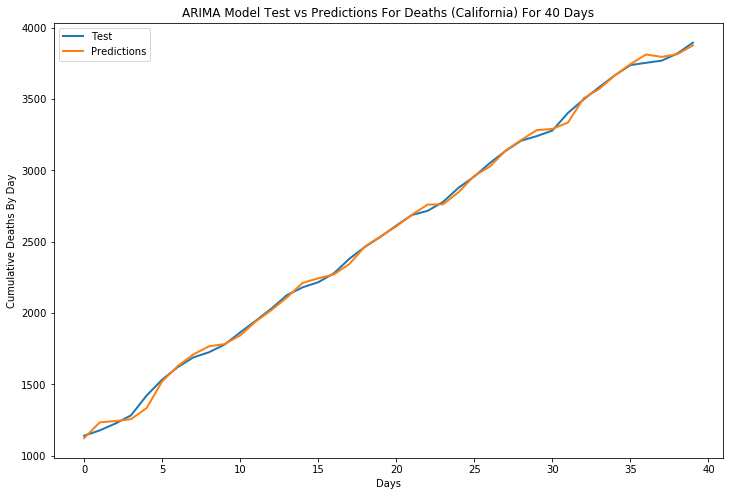

In [4]:
# Plot test (actual) vs predictions, save, and forecast
tpsf1.driver(arg_dict)

The California prediction is for 40,212 cumulative Deaths to occur by 2020-12-31 00:00:00


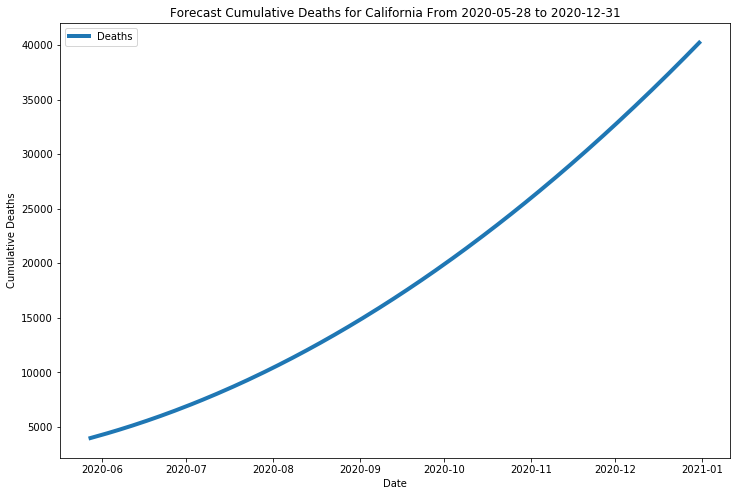

In [5]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to flatten the curve by the date indicated. We truncate the prediction at that point.

In [6]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail() 

Actual


,Deaths,Daily_Deaths
Date_,,
2020-05-23,3738.0,72.0
2020-05-24,3754.0,16.0
2020-05-25,3769.0,15.0
2020-05-26,3819.0,50.0
2020-05-27,3895.0,76.0


In [7]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head()

Predicted


,Deaths,Daily_Deaths
Date_,,
2020-05-28,3967.0,72.0
2020-05-29,4038.0,71.0
2020-05-30,4109.0,71.0
2020-05-31,4181.0,72.0
2020-06-01,4254.0,73.0
